In [1]:
!wget https://download.pytorch.org/tutorial/data.zip

--2019-07-28 09:05:25--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.168.110, 99.84.168.27, 99.84.168.34, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.168.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.2’

data.zip.2          100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2019-07-28 09:05:25 (39.7 MB/s) - ‘data.zip.2’ saved [2882130/2882130]



In [0]:
!unzip data.zip

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [0]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8'). \
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


In [0]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
random.shuffle(pairs)
training_data = pairs[0:int(math.floor(0.9 * len(pairs)))]
testing_data = pairs[int(math.floor(0.9 * len(pairs))) + 1:]
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['j ai des ennuis jusqu au cou .', 'i m in way over my head .']


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)



In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, attention,
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            if attention == True:
              decoder_output, decoder_hidden, decoder_attention = decoder(
                  decoder_input, decoder_hidden, encoder_outputs)
            else:
              decoder_output, decoder_hidden = decoder(
                  decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if attention == True:
              decoder_output, decoder_hidden, decoder_attention = decoder(
                  decoder_input, decoder_hidden, encoder_outputs)
            else:
              decoder_output, decoder_hidden = decoder(
                  decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def eval(input_tensor, target_tensor, encoder, decoder, criterion, attention, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        if attention == True:
              decoder_output, decoder_hidden, decoder_attention = decoder(
                  decoder_input, decoder_hidden, encoder_outputs)
        else:
          decoder_output, decoder_hidden = decoder(
               decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length



In [0]:
def trainIters(encoder, decoder, n_iters, attention, print_every=2000, plot_every=1000, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    plot_test_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(training_data))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, attention)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        # Compute loss based on test data
        if iter % plot_every == 0:
            test_loss = 0
            for testing_pair in testing_data:
                testing_pair_tensor = tensorsFromPair(testing_pair)
                input_tensor = testing_pair_tensor[0]
                target_tensor = testing_pair_tensor[1]
                test_loss = test_loss + eval(input_tensor, target_tensor, encoder, decoder, criterion, attention)
            plot_test_losses.append(test_loss / len(testing_data))

    showPlot(plot_test_losses)
    return plot_test_losses

In [0]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

0m 42s (- 24m 20s) (2000 2%) 3.2550
1m 30s (- 24m 51s) (4000 5%) 2.7087
2m 17s (- 24m 28s) (6000 8%) 2.5221
3m 5s (- 23m 56s) (8000 11%) 2.4098
3m 52s (- 23m 14s) (10000 14%) 2.2683
4m 39s (- 22m 30s) (12000 17%) 2.1208
5m 26s (- 21m 45s) (14000 20%) 1.9671
6m 13s (- 21m 1s) (16000 22%) 1.8493
7m 1s (- 20m 16s) (18000 25%) 1.7921
7m 48s (- 19m 30s) (20000 28%) 1.6812
8m 35s (- 18m 45s) (22000 31%) 1.6056
9m 22s (- 17m 58s) (24000 34%) 1.5412
10m 10s (- 17m 13s) (26000 37%) 1.4805
10m 58s (- 16m 27s) (28000 40%) 1.4094
11m 45s (- 15m 40s) (30000 42%) 1.3289
12m 33s (- 14m 54s) (32000 45%) 1.2470
13m 20s (- 14m 7s) (34000 48%) 1.2400
14m 7s (- 13m 20s) (36000 51%) 1.1773
14m 55s (- 12m 33s) (38000 54%) 1.1209
15m 42s (- 11m 46s) (40000 57%) 1.0665
16m 30s (- 11m 0s) (42000 60%) 0.9778
17m 18s (- 10m 13s) (44000 62%) 0.9817
18m 5s (- 9m 26s) (46000 65%) 0.9304
18m 53s (- 8m 39s) (48000 68%) 0.8977
19m 41s (- 7m 52s) (50000 71%) 0.8668
20m 29s (- 7m 5s) (52000 74%) 0.8203
21m 17s (- 6m 18s

<Figure size 432x288 with 0 Axes>

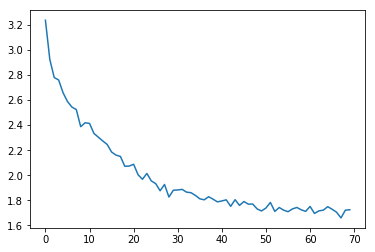

In [16]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

attention_losses = trainIters(encoder1, attn_decoder1, 70000, True)

0m 30s (- 17m 1s) (2000 2%) 3.3024
1m 1s (- 17m 2s) (4000 5%) 2.7868
1m 35s (- 16m 54s) (6000 8%) 2.5723
2m 8s (- 16m 36s) (8000 11%) 2.4194
2m 42s (- 16m 13s) (10000 14%) 2.3174
3m 15s (- 15m 46s) (12000 17%) 2.1591
3m 49s (- 15m 17s) (14000 20%) 2.0459
4m 22s (- 14m 47s) (16000 22%) 1.9406
4m 57s (- 14m 18s) (18000 25%) 1.8374
5m 31s (- 13m 47s) (20000 28%) 1.7662
6m 4s (- 13m 16s) (22000 31%) 1.6750
6m 38s (- 12m 43s) (24000 34%) 1.5574
7m 12s (- 12m 11s) (26000 37%) 1.4780
7m 46s (- 11m 39s) (28000 40%) 1.4053
8m 20s (- 11m 7s) (30000 42%) 1.3555
8m 54s (- 10m 34s) (32000 45%) 1.2864
9m 28s (- 10m 1s) (34000 48%) 1.2584
10m 2s (- 9m 29s) (36000 51%) 1.1799
10m 36s (- 8m 55s) (38000 54%) 1.1097
11m 10s (- 8m 22s) (40000 57%) 1.0460
11m 44s (- 7m 49s) (42000 60%) 1.0204
12m 18s (- 7m 16s) (44000 62%) 0.9731
12m 52s (- 6m 43s) (46000 65%) 0.9079
13m 26s (- 6m 9s) (48000 68%) 0.8946
14m 0s (- 5m 36s) (50000 71%) 0.8062
14m 34s (- 5m 2s) (52000 74%) 0.7736
15m 8s (- 4m 29s) (54000 77%) 

<Figure size 432x288 with 0 Axes>

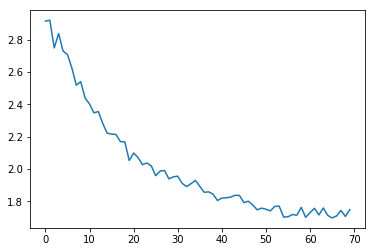

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

without_attention_losses = trainIters(encoder1, decoder1, 70000, False)

<Figure size 432x288 with 0 Axes>

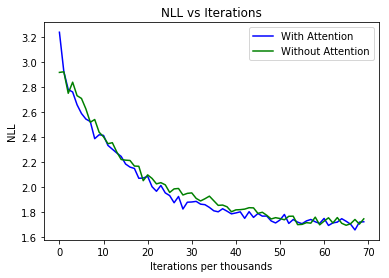

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(attention_losses,'b',label='With Attention')
plt.plot(without_attention_losses,'g',label='Without Attention')


plt.title('NLL vs Iterations')
plt.xlabel("Iterations per thousands")
plt.ylabel("NLL")
plt.legend()
plt.savefig("attention_graph.png")
plt.figure()
